# Klasyfikacja niezbalansowana, klasyfikatory zespołowe i wyjaśnialna AI

## Wykorzystanie Google Colab

Jeśli korzystasz z Google Colab skopiuj plik `feature_names.json` do katalogu głównego projektu.

Pamiętaj o zainstalowaniu zależności z użyciem `uv` lub `pip`.

## Ładowanie i eksploracja danych

W trakcie tych zajęć laboratoryjnych wykorzystamy zbiór danych [Polish companies bankruptcy](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data). Dotyczy on klasyfikacji, na podstawie danych z raportów finansowych, czy firma zbankrutuje w ciągu najbliższych kilku lat. Jest to zadanie szczególnie istotne dla banków, funduszy inwestycyjnych, firm ubezpieczeniowych itp. Zbiór zawiera 64 cechy obliczonych przez ekonomistów. Są one opisane na wspomnianej wcześniej stronie. Dotyczą one zysków firm, posiadanych zasobów, długów itp.

Ściągnij i rozpakuj dane (`Data Folder` -> `data.zip`) do katalogu `data` obok tego notebooka. Znajduje się tam 5 plików w formacie `.arff`, wykorzystywanym głównie przez oprogramowanie Weka. Jest to program do wyposażony w graficzny interfejs użytkownika, który był często używany przez mniej techincznie obeznanych użytkowników. W Pythonie dane w tym formacie ładuje się  za pomocą bibliotek SciPy i Pandas.


Jeśli korzystasz z Linuksa możesz skorzystać z poniższych poleceń do pobrania i rozpakowania tych plików.

In [1]:
#!mkdir -p data
#!wget https://archive.ics.uci.edu/static/public/365/polish+companies+bankruptcy+data.zip -O data/data.zip

In [2]:
#!unzip data/data.zip -d data


W dalszej części laboratorium wykorzystamy plik `3year.arff`, w którym na podstawie danych finansowych firmy po 3 latach monitorowania chcemy przewidywać, czy firma zbankrutuje w ciągu najbliższych 3 lat. Jest to dość realistyczny horyzont czasowy.

Dodatkowo w pliku `feature_names.json` znajdują się nazwy cech. Nazwy są bardzo długie, więc póki co nie będziemy z nich korzystać.

In [3]:
import json
import os
import numpy as np

from scipy.io import arff
import pandas as pd

data = arff.loadarff(os.path.join("data", "3year.arff"))

with open("feature_names.json") as file:
    feature_names = json.load(file)

X = pd.DataFrame(data[0])

Przyjrzyjmy się teraz naszym danym.

In [4]:
X.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [5]:
X.dtypes

Attr1     float64
Attr2     float64
Attr3     float64
Attr4     float64
Attr5     float64
           ...   
Attr61    float64
Attr62    float64
Attr63    float64
Attr64    float64
class      object
Length: 65, dtype: object

In [6]:
X.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,...,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,...,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,...,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,...,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.000000,0.050945,1.111000,1.199000,0.515500,...,8.822900e+02,0.051765,0.106880,0.953060,0.002976,9.952100e+00,6.677300,7.066400e+01,5.139200,4.059300
75%,0.123805,0.689330,0.419545,2.959500,5.608400e+01,0.072584,0.142275,2.857100,2.059100,0.725635,...,4.348900e+03,0.130010,0.271310,0.995927,0.240320,2.093600e+01,10.587500,1.182200e+02,8.882600,9.682750
max,52.652000,480.730000,17.708000,53433.000000,6.854400e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,3.380500e+06,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4470.400000,1.073500e+06,1974.500000,21499.000000


In [7]:
feature_names

['net profit / total assets',
 'total liabilities / total assets',
 'working capital / total assets',
 'current assets / short-term liabilities',
 '[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365',
 'retained earnings / total assets',
 'EBIT / total assets',
 'book value of equity / total liabilities',
 'sales / total assets',
 'equity / total assets',
 '(gross profit + extraordinary items + financial expenses) / total assets',
 'gross profit / short-term liabilities',
 '(gross profit + depreciation) / sales',
 '(gross profit + interest) / total assets',
 '(total liabilities * 365) / (gross profit + depreciation)',
 '(gross profit + depreciation) / total liabilities',
 'total assets / total liabilities',
 'gross profit / total assets',
 'gross profit / sales',
 '(inventory * 365) / sales',
 'sales (n) / sales (n-1)',
 'profit on operating activities / total assets',
 'net profit / sales',
 'gross profit (in 3 years) / 

DataFrame zawiera 64 atrybuty numeryczne o zróżnicowanych rozkładach wartości oraz kolumnę `"class"` typu `bytes` z klasami 0 i 1. Wiemy, że mamy do czynienia z klasyfikacją binarną - klasa 0 to brak bankructwa, klasa 1 to bankructwo w ciągu najbliższych 3 lat. Przyjrzyjmy się dokładniej naszym danym.

### Zadanie 1 (0.5 punktu)

1. Wyodrębnij klasy jako osobną zmienną typu `pd.Series`, usuwając je z macierzy `X`. Przekonwertuj je na liczby całkowite.
2. Narysuj wykres słupkowy częstotliwości obu klas w całym zbiorze. Upewnij się, że na osi X są numery lub nazwy klas, a oś Y ma wartości w procentach.

**Uwaga:** sugerowane jest użycie `if` w podpunkcie 1, żeby można było tę komórkę bezpiecznie odpalić kilka razy.

Text(0, 0.5, 'frequency')

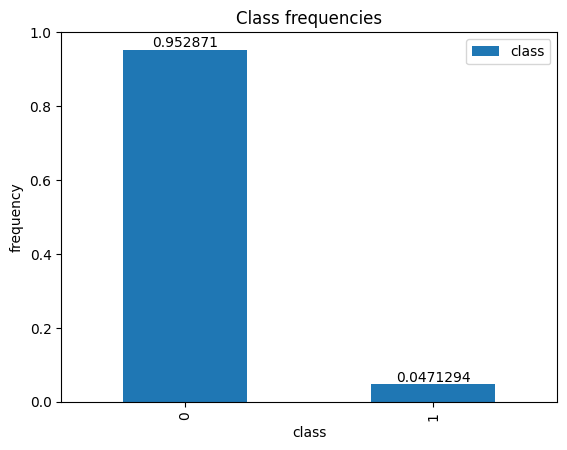

In [8]:
if "class" in X.columns:
    y = X.pop("class").astype(np.int64)

ax = pd.DataFrame({'class': np.array(y.value_counts(normalize=True))}, index=['0', '1']).plot.bar()
ax.bar_label(ax.containers[0])
ax.set_title("Class frequencies")
ax.set_xlabel("class")
ax.set_ylabel("frequency")

In [9]:
assert "class" not in X.columns

print("Solution is correct!")

Solution is correct!


Jak widać, klasa pozytywna jest w znacznej mniejszości, stanowi poniżej 5% zbioru. Taki problem nazywamy **klasyfikacją niezbalansowaną (imbalanced classification)**. Mamy tu **klasę dominującą (majority class)** oraz **klasę mniejszościową (minority class)**. Pechowo prawie zawsze interesuje nas ta druga, bo klasa większościowa nie niesie najczęściej żadnych interesujących informacji. Przykładowo, 99% badanych jest zdrowych, a 1% ma niewykryty nowotwór - z oczywistych przyczyn chcemy wykrywać właśnie sytuację rzadką (problem diagnozy jako klasyfikacji jest zasadniczo zawsze niezbalansowany). W dalszej części laboratorium poznamy szereg konsekwencji tego zjawiska i metody na radzenie sobie z nim.

Mamy sporo cech w naszym zbiorze, wszystkie są numeryczne. Ciekawe, czy mają wartości brakujące, a jeśli tak, to ile? Policzymy to z pomocą biblioteki Pandas i metody `.isna()`. Domyślnie operuje ona na kolumnach, jak większość metod w w tej bibliotece. Sumę wartości per kolumna zwróci nam metoda `.sum()`. Jeżeli podzielimy to przez liczbę wierszy `len(X)`, to otrzymamy ułamek wartości brakujących w każdej kolumnie.

Biblioteka Pandas potrafi też stworzyć wykres, z pomocą funkcji np. `.plot.hist()` czy `.plot.bar()`. Przyjmują one opcje formatowania wykresu z których korzysta biblioteka `matplotlib`.

<Axes: title={'center': 'Fraction of missing values per column'}>

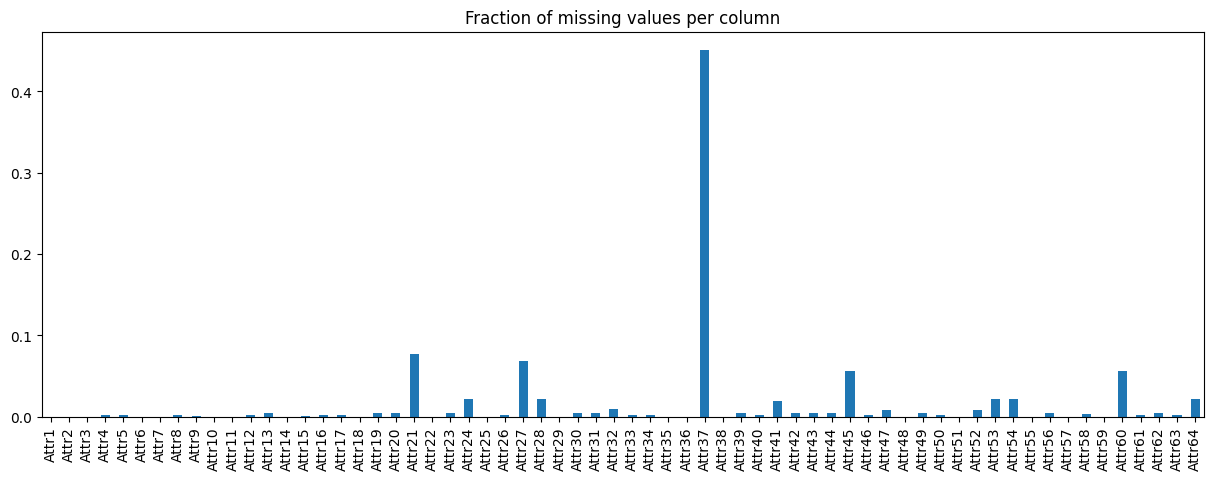

In [10]:
na_perc = X.isna().sum() / len(X)
na_perc.plot.bar(title="Fraction of missing values per column", figsize=(15, 5))

Jak widać, cecha 37 ma bardzo dużo wartości brakujących, podczas gdy pozostałe cechy mają raczej niewielką ich liczbę. W takiej sytuacji najlepiej usunąć tę cechę, a pozostałe wartości brakujące **uzupełnić** (co realizowaliśmy już poprzednio). Pamiętaj, że imputacji dokonuje się dopiero po podziale na zbiór treningowy i testowy! W przeciwnym wypadku wykorzystywalibyśmy dane ze zbioru testowego, co sztucznie zawyżyłoby wyniki. Jest to błąd metodologiczny - **wyciek danych (data leakage)**.

Podział na zbiór treningowy i testowy to pierwszy moment, kiedy niezbalansowanie danych nam przeszkadza. Jeżeli zrobimy to czysto losowo, to jest spora szansa, że w zbiorze testowym będzie tylko klasa negatywna - w końcu jest jej aż >95%. Dlatego wykorzystuje się **próbkowanie ze stratyfikacją (stratified sampling)**, dzięki któremu proporcje klas w zbiorze przed podziałem oraz obu zbiorach po podziale są takie same.

### Zadanie 2 (0.75 punktu)

1. Usuń kolumnę `"Attr37"` ze zbioru danych.
2. Dokonaj podziału zbioru na treningowy i testowy w proporcjach 80%-20%, z przemieszaniem (`shuffle`), ze stratyfikacją, wykorzystując funkcję `train_test_split` ze Scikit-learn'a.
3. Uzupełnij wartości brakujące średnią wartością cechy z pomocą klasy `SimpleImputer`.

**Uwaga:**
- jak wcześniej, sugerowane jest użycie `if` w podpunkcie 1,
- pamiętaj o uwzględnieniu stałego ziarna `random_state=0`, aby wyniki były **reprodukowalne (reproducible)**,
- `stratify` oczekuje wektora klas,
- wartości do imputacji trzeba wyestymować na zbiorze treningowym (`.fit()`), a potem zastosować te nauczone wartości na obu podzbiorach (treningowym i testowym).

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

if "Attr37" in X.columns:
    X = X.drop("Attr37", axis="columns")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

mean_imputer = SimpleImputer()
X_train = mean_imputer.fit_transform(X_train)
X_test = mean_imputer.transform(X_test)

In [12]:
import numpy as np

assert "Attr37" not in X.columns
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(X_test))

print("Solution is correct!")

Solution is correct!


## Prosta klasyfikacja

Zanim przejdzie się do modeli bardziej złożonych, trzeba najpierw wypróbować coś prostego, żeby mieć punkt odniesienia. Tworzy się dlatego **modele bazowe (baselines)**.

W naszym przypadku będzie to **drzewo decyzyjne (decision tree)**. Jest to drzewo binarne z decyzjami if-else, prowadzącymi do klasyfikacji danego przykładu w liściu. Każdy podział w drzewie to pytanie postaci "Czy wartość cechy X jest większa lub równa Y?". Trening takiego drzewa to prosty algorytm zachłanny, bardzo przypomina budowę zwykłego drzewa binarnego. Ma on następujące kroki dla każdego węzła tego drzewa:
1. Sprawdź po kolei wszystkie możliwe punkty podziału, czyli każdą (unikalną) wartość każdej cechy, po kolei.
2. Dla każdego przypadku podziel zbiór na 2 części: niespełniający warunku (lewy potomek) i spełniający warunek (prawy potomek).
3. Oblicz jakość podziału według wybranej funkcji jakości. Im lepiej warunek rozdziela klasy od siebie (imbardziej zunifikowane są węzły-dzieci), tym wyższa jakość podziału. Innymi słowy, chcemy, żeby do jednego dziecka trafiła jedna klasa, a do drugiego druga.
4. Wybierz podział o najwyższej jakości.

Taki algorytm wykonuje się rekurencyjnie, aż otrzymamy węzeł czysty (pure leaf), czyli taki, w którym są przykłady z tylko jednej klasy. Typowo wykorzystywaną funkcją jakości (kryterium podziału) jest entropia Shannona - im niższa entropia, tym bardziej jednolite są klasy w węźle (czyli wybieramy podział o najniższej entropii).

Powyższe wytłumaczenie algorytmu jest oczywiście nieformalne i dość skrótowe. Doskonałe tłumaczenie, z interaktywnymi wizualizacjami, dostępne jest [tutaj](https://mlu-explain.github.io/decision-tree/). W formie filmów - [tutaj](https://www.youtube.com/watch?v=ZVR2Way4nwQ) oraz [tutaj](https://www.youtube.com/watch?v=_L39rN6gz7Y). Dla drzew do regresji - [ten film](https://www.youtube.com/watch?v=g9c66TUylZ4).

<img src = https://miro.medium.com/max/1838/1*WyTsLwcAXivFCgNtF0OPqA.png width = "642" height = "451" >

Warto zauważyć, że taka konstrukcja prowadzi zawsze do overfittingu. Otrzymanie liści czystych oznacza, że mamy 100% dokładności na zbiorze treningowym, czyli perfekcyjnie przeuczony klasyfikator. W związku z tym nasze predykcje mają bardzo niski bias, ale bardzo dużą wariancję. Pomimo tego drzewa potrafią dać bardzo przyzwoite wyniki, a w celu ich poprawy można je regularyzować, aby mieć mniej "rozrośnięte" drzewo. [Film dla zainteresowanych](https://www.youtube.com/watch?v=D0efHEJsfHo).


Mając wytrenowany klasyfikator, trzeba oczywiście sprawdzić, jak dobrze on sobie radzi. Tu natrafiamy na kolejny problem z klasyfikacją niezbalansowaną - zwykła celność (accuracy) na pewno nie zadziała! Typowo wykorzystuje się AUC, nazywane też AUROC (Area Under Receiver Operating Characteristic), bo metryka ta uwzględnia niezbalansowanie klas. 

Bardzo dobre i bardziej szczegółowe wytłumaczenie, z interktywnymi wizualizacjami, można znaleć [tutaj](https://mlu-explain.github.io/roc-auc/). Dla preferujących filmy - [tutaj](https://www.youtube.com/watch?v=4jRBRDbJemM).

Co ważne, z definicji AUROC, trzeba w niej użyć **prawdopodobieństw klasy pozytywnej** (klasy 1). W Scikit-learn'ie zwraca je metoda `.predict_proba()`, która w kolejnych kolumnach zwraca prawdopodobieństwa poszczególnych klas.

### Zadanie 3 (0.75 punktu)

1. Wytrenuj klasyfikator drzewa decyzyjnego (klasa `DecisionTreeClassifier`). Użyj entropii jako kryterium podziału.
2. Oblicz i wypisz AUROC na zbiorze testowym dla drzewa decyzyjnego (funkcja `roc_auc_score`).
3. Skomentuj wynik - czy twoim zdaniem osiągnięty AUROC to dużo czy mało, biorąc pod uwagę możliwy zakres wartości tej metryki?

**Uwaga:**
- pamiętaj o użyciu stałego ziarna `random_state=0`,
- jeżeli drzewo nie wyświetli się samo, użyj `plt.show()` z Matplotliba,
- pamiętaj o tym, żeby przekazać do metryki AUROC **prawdopodobieństwa klasy pozytywnej**, a nie binarne predykcje!

AUROC: 0.7266899766899767


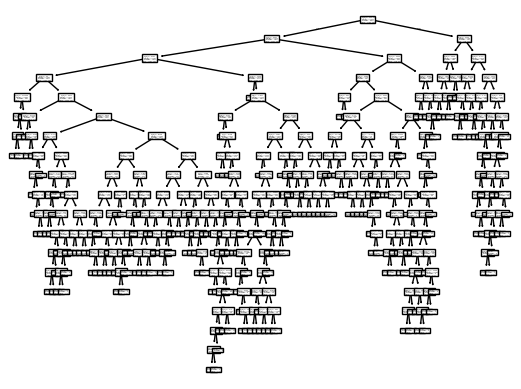

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import tree

clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
clf.fit(X_train, y_train)
tree.plot_tree(clf)

auroc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"AUROC: {auroc}")

In [14]:
assert auroc > 0.7

print("Solution is correct!")

Solution is correct!


Wiedząc, że AUROC osiąga wartości z przedziału [0;1], jest to wartość nienajniższa. Jednakże raczej chcielibyśmy, by była ona większa - conajmniej 0.9.

## Uczenie zespołowe, bagging, lasy losowe

Bardzo często wiele klasyfikatorów działających razem daje lepsze wyniki niż pojedynczy klasyfikator. Takie podejście nazywa się **uczeniem zespołowym (ensemble learning)**. Istnieje wiele różnych podejść do tworzenia takich klasyfikatorów złożonych (ensemble classifiers).

Podstawową metodą jest **bagging**:
1. Wylosuj N (np. 100, 500, ...) próbek boostrapowych (boostrap sample) ze zbioru treningowego. Próbka boostrapowa to po prostu losowanie ze zwracaniem, gdzie dla wejściowego zbioru z M wierszami losujemy M próbek (czyli tyle ile było w początkowym zbiorze), spośród N wylosowanych próbek. Będą tam powtórzenia, średnio nawet 1/3, ale się tym nie przejmujemy.
2. Wytrenuj klasyfikator bazowy (base classifier) na każdej z próbek boostrapowych.
3. Stwórz klasyfikator złożony poprzez uśrednienie predykcji każdego z klasyfikatorów bazowych.

<img src = https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/440px-Ensemble_Bagging.svg.png width = "440" height = "248" >

Typowo klasyfikatory bazowe są bardzo proste, żeby można było szybko wytrenować ich dużą liczbę. Prawie zawsze używa się do tego drzew decyzyjnych. Dla klasyfikacji uśrednienie wyników polega na głosowaniu - dla nowej próbki każdy klasyfikator bazowy ją klasyfikuje, sumuje się głosy na każdą klasę i zwraca najbardziej popularną decyzję.

Taki sposób uczenia zmniejsza wariancję klasyfikatora. Intuicyjnie, skoro coś uśredniamy, to siłą rzeczy będzie mniej rozrzucone, bo dużo ciężej będzie osiągnąć jakąś skrajność. Redukuje to też overfitting.

**Lasy losowe (Random Forests)** to ulepszenie baggingu. Zaobserwowano, że pomimo losowania próbek boostrapowych, w baggingu poszczególne drzewa są do siebie bardzo podobne (są skorelowane), używają podobnych cech ze zbioru. My natomiast chcemy zróżnicowania, żeby mieć niski bias - redukcją wariancji zajmuje się uśrednianie. Dlatego używa się metody losowej podprzestrzeni (random subspace method) - przy każdym podziale drzewa losuje się tylko pewien podzbiór cech, których możemy użyć do tego podziału. Typowo jest to pierwiastek kwadratowy z ogólnej liczby cech.

Zarówno bagging, jak i lasy losowe mają dodatkowo bardzo przyjemną własność - są mało czułe na hiperparametry, szczególnie na liczbę drzew. W praktyce wystarczy ustawić 500 czy 1000 drzew i klasyfikator będzie dobrze działać. Dalsze dostrajanie hiperparametrów może jeszcze trochę poprawić wyniki, ale nie tak bardzo, jak przy innych klasyfikatorach. Jest to zatem doskonały wybór domyślny, kiedy nie wiemy, jakiego klasyfikatora użyć.

Dodatkowo jest to problem **embarassingly parallel** - drzewa można trenować w 100% równolegle, dzięki czemu jest to dodatkowo wydajna obliczeniowo metoda.

Głębsze wytłumaczenie, z interaktywnymi wizualizacjami, można znaleźć [tutaj](https://mlu-explain.github.io/random-forest/). Dobrze tłumaczy je też [ta seria filmów](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&t=480s).

### Zadanie 4 (0.5 punktu)

1. Wytrenuj klasyfikator Random Forest (klasa `RandomForestClassifier`). Użyj 500 drzew i entropii jako kryterium podziału.
2. Sprawdź AUROC na zbiorze testowym.
3. Skomentuj wynik w odniesieniu do drzewa decyzyjnego.

**Uwaga:** pamiętaj o ustawieniu `random_state=0`. Dla przyspieszenia ustaw `n_jobs=-1` (użyje tylu procesów, ile masz dostępnych rdzeni procesora). Pamiętaj też o przekazaniu prawdopodobieństw do metryki AUROC.

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=0, n_jobs=-1)
rfc.fit(X_train, y_train)

auroc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
print(f"AUROC: {auroc}")

AUROC: 0.8986669895760804


In [16]:
assert auroc > 0.85

print("Solution is correct!")

Solution is correct!


AUROC w tym przypadku jest zdecydowanie lepszy niż dla drzewa decyzyjnego. Jest to już wartość, którą można uznać za dobrą, lecz chcielibyśmy najchętniej ją jeszcze bardzie zwiększyć.

Jak zobaczymy poniżej, wynik ten możemy jednak jeszcze ulepszyć!

## Oversampling, SMOTE

W przypadku zbiorów niezbalansowanych można dokonać **balansowania (balancing)** zbioru. Są tutaj 2 metody:
- **undersampling**: usunięcie przykładów z klasy dominującej
- **oversampling**: wygenerowanie dodatkowych przykładów z klasy mniejszościowej

Undersampling działa dobrze, kiedy niezbalansowanie jest niewielkie, a zbiór jest duży (możemy sobie pozwolić na usunięcie jego części). Oversampling typowo daje lepsze wyniki, istnieją dla niego bardzo efektywne algorytmy. W przypadku bardzo dużego niezbalansowania można zrobić oba.

Typowym algorytmem oversamplingu jest **SMOTE (Synthetic Minority Oversampling TEchnique)**. Działa on następująco:
1. Idź po kolei po przykładach z klasy mniejszościowej.
2. Znajdź `k` najbliższych przykładów dla próbki, typowo `k=5`.
3. Wylosuj tylu sąsiadów, ile trzeba do oversamplingu, np. jeżeli chcemy zwiększyć klasę mniejszościową 3 razy (o 200%), to wylosuj 2 z 5 sąsiadów.
4. Dla każdego z wylosowanych sąsiadów wylosuj punkt na linii prostej między próbką a tym sąsiadem. Dodaj ten punkt jako nową próbkę do zbioru.

<img src = https://miro.medium.com/max/734/1*yRumRhn89acByodBz0H7oA.png >

Taka technika generuje przykłady bardzo podobne do prawdziwych, więc nie zaburza zbioru, a jednocześnie pomaga klasyfikatorom, bo "zagęszcza" przestrzeń, w której znajduje się klasa pozytywna.

Algorytm SMOTE, jego warianty i inne algorytmy dla problemów niezbalansowanych implementuje biblioteka Imbalanced-learn.

### Zadanie 5 (1 punkt)

Użyj SMOTE do zbalansowania zbioru treningowego (nie używa się go na zbiorze testowym!). Implementuje to klasa `SMOTE`. Wytrenuj drzewo decyzyjne oraz las losowy na zbalansowanym zbiorze, użyj tych samych argumentów co wcześniej. Pamiętaj o użyciu wszędzie stałego ziarna `random_state=0` oraz przekazaniu prawdopodobieństw do AUROC. Skomentuj wynik.

Wartość ROC drzewa decyzyjnego przypisz do zmiennej `tree_roc`, a lasu do `forest_roc`.

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
clf.fit(X_train, y_train)

rfc = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=0, n_jobs=-1)
rfc.fit(X_train, y_train)

tree_roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"Tree AUROC: {tree_roc}")
forest_roc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
print(f"Forest AUROC: {forest_roc}")

Tree AUROC: 0.70995670995671
Forest AUROC: 0.9046609955700865


In [18]:
assert 0.6 < tree_roc < 0.8
assert 0.8 < forest_roc < 0.95

print("Solution is correct!")

Solution is correct!


Różnice AUROC dla obu przypadków nie są ogromne, ale są zauważalne. Ciekawym jest to, że w przypadku drzewa decyzyjnego ta wartość zmalała, co oczywiśnie nie jest porządanym efektem.

W dalszej części laboratorium używaj zbioru po zastosowaniu SMOTE do treningu klasyfikatorów.

## Dostrajanie (tuning) hiperparametrów

Lasy losowe są stosunkowo mało czułe na dobór hiperparametrów - i dobrze, bo mają ich dość dużo. Można zawsze jednak spróbować to zrobić, a w szczególności najważniejszy jest parametr `max_features`, oznaczający, ile cech losować przy każdym podziale drzewa. Typowo sprawdza się wartości z zakresu `[0.1, 0.5]`.

W kwestii szybkości, kiedy dostrajamy hiperparametry, to mniej oczywiste jest, jakiego `n_jobs` użyć. Z jednej strony klasyfikator może być trenowany na wielu procesach, a z drugiej można trenować wiele klasyfikatorów na różnych zestawach hiperparametrów równolegle. Jeżeli nasz klasyfikator bardzo dobrze się uwspółbieżnia (jak Random Forest), to można dać mu nawet wszystkie rdzenie, a za to wypróbowywać kolejne zestawy hiperparametrów sekwencyjnie. Warto ustawić parametr `verbose` na 2 lub więcej, żeby dostać logi podczas długiego treningu i mierzyć czas wykonania. W praktyce ustawia się to metodą prób i błędów.

### Zadanie 6 (1 punkt)

1. Dobierz wartość hiperparametru `max_features`:
   - użyj grid search z 5 foldami,
   - wypróbuj wartości `[0.1, 0.2, 0.3, 0.4, 0.5]`,
   - wybierz model o najwyższym AUROC (argument `scoring`).
2. Sprawdź, jaka była optymalna wartość `max_features`. Jest to atrybut wytrenowanego `GridSearchCV`.
3. Skomentuj wynik. Czy warto było poświęcić czas i zasoby na tę procedurę?
4. Wynik przypisz do zmiennej `auroc`.

**Uwaga:**
- pamiętaj, żeby jako estymatora przekazanego do grid search'a użyć instancji Random Forest, która ma już ustawione `random_state=0` i `n_jobs`

In [19]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=0, n_jobs=-1)

gscv = GridSearchCV(rfc, {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5]}, cv=5, scoring="roc_auc", verbose=2)
gscv.fit(X_train, y_train)

print(f"Best max feature param: {gscv.best_params_["max_features"]}")
auroc = roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1])
print(f"AUROC: {auroc}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................................max_features=0.1; total time=   5.1s
[CV] END ...................................max_features=0.1; total time=   5.1s
[CV] END ...................................max_features=0.1; total time=   5.1s
[CV] END ...................................max_features=0.1; total time=   5.1s
[CV] END ...................................max_features=0.1; total time=   5.1s
[CV] END ...................................max_features=0.2; total time=   9.1s
[CV] END ...................................max_features=0.2; total time=   9.1s
[CV] END ...................................max_features=0.2; total time=   9.2s
[CV] END ...................................max_features=0.2; total time=   9.2s
[CV] END ...................................max_features=0.2; total time=   9.3s
[CV] END ...................................max_features=0.3; total time=  12.9s


KeyboardInterrupt: 

In [ ]:
assert 0.9 <= auroc <= 0.95

print("Solution is correct!")

Patrząc na to, że AUROC się polepszyło o mniej niż 0.01, to spędzenie kilku dodatkowych minut nie wydaje się mieć za dużo sensu. Jednakże to zależy bardzo od tego jak bardzo ważna jest dokładność naszego modelu. Należy też zwrócić uwagę na to, że kilka minut na laptopie stałoby się maksymalnie kilkoma sekundami na lepszym sprzęcie, i wtedy zdecydowanie warto by było z tego skorzystać.

W praktycznych zastosowaniach osoba trenująca model wedle własnego uznana, doświadczenia, dostępnego czasu i zasobów wybiera, czy dostrajać hiperparametry i w jak szerokim zakresie. Dla Random Forest na szczęście często może nie być znaczącej potrzeby i za to go lubimy :)

**Random Forest - podsumowanie**

1. Model oparty o uczenie zespołowe.
2. Kluczowe elementy:
   - bagging: uczenie wielu klasyfikatorów na próbkach boostrapowych,
   - metoda losowej podprzestrzeni: losujemy podzbiór cech do każdego podziału drzewa,
   - uśredniamy głosy klasyfikatorów.
3. Dość odporny na overfitting, zmniejsza wariancję błędu dzięki uśrednianiu.
4. Mało czuły na hiperparametry.
5. Przeciętnie daje bardzo dobre wyniki, doskonały wybór domyślny przy wybieraniu algorytmu klasyfikacji.

## Boosting

Drugą bardzo ważną grupą algorytmów ensemblingu jest **boosting**, też oparty o drzewa decyzyjne. O ile Random Forest trenował wszystkie klasyfikatory bazowe równolegle i je uśredniał, o tyle boosting robi to sekwencyjnie. Drzewa te uczą się na całym zbiorze, nie na próbkach boostrapowych. Idea jest następująca: trenujemy drzewo decyzyjne, radzi sobie przeciętnie i popełnia błędy na częsci przykładów treningowych. Dokładamy kolejne, ale znające błędy swojego poprzednika, dzięki czemu może to uwzględnić i je poprawić. W związku z tym "boostuje" się dzięki wiedzy od poprzednika. Dokładamy kolejne drzewa zgodnie z tą samą zasadą.

Jak uczyć się na błędach poprzednika? Jest to pewna **funkcja kosztu** (błędu), którą chcemy zminimalizować. Zakłada się jakąś jej konkretną postać, np. squared error dla regresji, albo logistic loss dla klasyfikacji. Później wykorzystuje się spadek wzdłuż gradientu (gradient descent), aby nauczyć się, w jakim kierunku powinny optymalizować kolejne drzewa, żeby zminimalizować błędy poprzednika. Jest to konkretnie **gradient boosting**, absolutnie najpopularniejsza forma boostingu, i jeden z najpopularniejszych i osiągających najlepsze wyniki algorytmów ML.

Tyle co do intuicji. Ogólny algorytm gradient boostingu jest trochę bardziej skomplikowany. Bardzo dobrze i krok po kroku tłumaczy go [ta seria filmów na YT](https://www.youtube.com/watch?v=3CC4N4z3GJc). Szczególnie ważne implementacje gradient boostingu to **XGBoost (Extreme Gradient Boosting)** oraz **LightGBM (Light Gradient Boosting Machine)**. XGBoost był prawdziwym przełomem w ML, uzyskując doskonałe wyniki i bardzo dobrze się skalując - był wykorzystany w CERNie do wykrywania cząstki Higgsa w zbiorze z pomiarów LHC mającym 10 milionów próbek. Jego implementacja jest dość złożona, ale dobrze tłumaczy ją [inna seria filmików na YT](https://www.youtube.com/watch?v=OtD8wVaFm6E).

![](xgboost.png)

Obecnie najczęściej wykorzystuje się LightGBM. Został stworzony przez Microsoft na podstawie doświadczeń z XGBoostem. Został jeszcze bardziej ulepszony i przyspieszony, ale różnice są głównie implementacyjne. Różnice dobrze tłumaczy [ta prezentacja z konferencji PyData](https://www.youtube.com/watch?v=5CWwwtEM2TA) oraz [prezentacja Microsoftu](https://www.youtube.com/watch?v=5nKSMXBFhes). Dla zainteresowanych - [praktyczne aspekty LightGBM](https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook).

### Zadanie 7 (0.5 punktu)

1. Wytrenuj klasyfikator LightGBM (klasa `LGBMClassifier`). Przekaż `importance_type="gain"` - przyda nam się to za chwilę.
2. Sprawdź AUROC na zbiorze testowym.
3. Skomentuj wynik w odniesieniu do wcześniejszych algorytmów.

Pamiętaj o `random_state`, `n_jobs` i prawdopodobieństwach dla AUROC.

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(importance_type="gain", random_state=0, n_jobs=-1)
lgbm.fit(X_train, y_train)

auroc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print(f"AUROC: {auroc}")

In [ ]:
assert 0.9 <= auroc <= 0.97

print("Solution is correct!")

Boosting okazał się bardzo dobrym wyborem. W bardzo krótkim czasie zdołał osiągnąć dużo lepszy AUROC niż poprzednie sposoby.

Boosting dzięki uczeniu na poprzednich drzewach redukuje nie tylko wariancję, ale też bias w błędzie, dzięki czemu może w wielu przypadkach osiągnąć lepsze rezultaty od lasu losowego. Do tego dzięki znakomitej implementacji LightGBM jest szybszy.

Boosting jest jednak o wiele bardziej czuły na hiperparametry niż Random Forest. W szczególności bardzo łatwo go przeuczyć, a większość hiperparametrów, których jest dużo, wiąże się z regularyzacją modelu. To, że teraz poszło nam lepiej z domyślnymi, jest rzadkim przypadkiem.

W związku z tym, że przestrzeń hiperparametrów jest duża, przeszukanie wszystkich kombinacji nie wchodzi w grę. Zamiast tego można wylosować zadaną liczbę zestawów hiperparametrów i tylko je sprawdzić - chociaż im więcej, tym lepsze wyniki powinniśmy dostać. Służy do tego `RandomizedSearchCV`. Co więcej, klasa ta potrafi próbkować rozkłady prawdopodobieństwa, a nie tylko sztywne listy wartości, co jest bardzo przydatne przy parametrach ciągłych.

Hiperparametry LightGBMa są dobrze opisane w oficjalnej dokumentacji: [wersja krótsza](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier) i [wersja dłuższa](https://lightgbm.readthedocs.io/en/latest/Parameters.html). Jest ich dużo, więc nie będziemy ich tutaj omawiać. Jeżeli chodzi o ich dostrajanie w praktyce, to przydatny jest [oficjalny przewodnik](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) oraz dyskusje na Kaggle.

### Zadanie 8 (1.5 punktu)

1. Zaimplementuj random search dla LightGBMa (klasa `RandomizedSearchCV`):
   - użyj tylu prób, na ile pozwalają twoje zasoby obliczeniowe, ale przynajmniej 30,
   - przeszukaj przestrzeń hiperparametrów:
    ```
    param_grid = {
        "n_estimators": [100, 250, 500],
        "learning_rate": [0.05, 0.1, 0.2],
        "num_leaves": [31, 48, 64],
        "colsample_bytree": [0.8, 0.9, 1.0],
        "subsample": [0.8, 0.9, 1.0],
    }
    ```
2. Wypisz znalezione optymalne hiperparametry.
3. Wypisz raporty z klasyfikacji (funkcja `classification_report`), dla modelu LightGBM bez i z dostrajaniem hiperparametrów.
4. Skomentuj różnicę precyzji (precision) i czułości (recall) między modelami bez i z dostrajaniem hiperparametrów. Czy jest to pożądane zjawisko w tym przypadku?
5. Wartość ROC przypisz do zmiennej `auroc`.

**Uwaga:** 
- koniecznie ustaw `verbose=-1` przy tworzeniu `LGBMClassifier`, żeby uniknąć kolosalnej ilości logów, która potrafi też wyłączyć Jupytera
- pamiętaj o ustawieniu `importance_type`, `random_state=0` i `n_jobs`, oraz ewentualnie `verbose` w `RandomizedSearchCV` dla śledzenia przebiegu
- istnieje możliwość, że ustawienie `n_jobs` dla grid searcha będzie szybsze niż dla samego LightGBM; odpowiada to tuningowi wielu klasyfikatorów równolegle, przy wolniejszym treningu pojedynczych klasyfikatorów
- nie ustawiaj wszędzie `n_jobs=-1`, bo wtedy stworzysz więcej procesów niż rdzeni i spowodujesz thread contention

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 250, 500],
    "learning_rate": [0.05, 0.1, 0.2],
    "num_leaves": [31, 48, 64],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "subsample": [0.8, 0.9, 1.0],
}
lgbm = LGBMClassifier(importance_type="gain", random_state=0, verbose=-1, n_jobs=1)
rscv = RandomizedSearchCV(lgbm, param_grid, n_iter=30, verbose=2, n_jobs=-1, scoring="roc_auc", random_state=0)
rscv.fit(X_train, y_train)

In [ ]:
print("Best params:")
[print(f"{p}: {rscv.best_params_[p]") for p in param_grid.keys()]

lgbm = LGBMClassifier(importance_type="gain", random_state=0, verbose=-1, n_jobs=-1)
lgbm.fit(X_train, y_train)
print("No tuning report:")
print(classification_report(y_test, lgbm.predict(X_test)))

print("Tuning report:")
print(classification_report(y_test, rscv.predict(X_test)))

auroc = roc_auc_score(y_test, rscv.predict_proba(X_test)[:,1])
print(f"AUROC: {auroc}")

In [ ]:
assert 0.9 <= auroc <= 0.99

print("Solution is correct!")

// skomentuj tutaj

**Boosting - podsumowanie**

1. Model oparty o uczenie zespołowe.
2. Kolejne modele są dodawane sekwencyjnie i uczą się na błędach poprzedników.
3. Nauka typowo jest oparta o minimalizację funkcji kosztu (błędu), z użyciem spadku wzdłuż gradientu.
4. Wiodący model klasyfikacji dla danych tabelarycznych, z 2 głównymi implementacjami: XGBoost i LightGBM.
5. Liczne hiperparametry, wymagające odpowiednich metod dostrajania.

## Wyjaśnialna AI

W ostatnich latach zaczęto zwracać coraz większą uwagę na wpływ sztucznej inteligencji na społeczeństwo, a na niektórych czołowych konferencjach ML nawet obowiązkowa jest sekcja "Social impact" w artykułach naukowych. Typowo im lepszy model, tym bardziej złożony, a najpopularniejsze modele boostingu są z natury skomplikowane. Kiedy mają podejmować krytyczne decyzje, to musimy wiedzieć, czemu predykcja jest taka, a nie inna. Jest to poddziedzina uczenia maszynowego - **wyjaśnialna AI (explainable AI, XAI)**.

Taka informacja jest cenna, bo dzięki temu lepiej wiemy, co robi model. Jest to ważne z kilku powodów:
1. Wymogi prawne - wdrażanie algorytmów w ekonomii, prawie etc. ma coraz częściej konkretne wymagania prawne co do wyjaśnialności predykcji.
2. Dodatkowa wiedza dla użytkowników - często dodatkowe obserwacje co do próbek są ciekawe same w sobie i dają wiedzę użytkownikowi (często posiadającemu specjalistyczną wiedzę z dziedziny), czasem nawet bardziej niż sam model predykcyjny.
3. Analiza modelu - dodatkowa wiedza o wewnętrznym działaniu algorytmu pozwala go lepiej zrozumieć i ulepszyć wyniki, np. przez lepszy preprocessing danych.

W szczególności można ją podzielić na **globalną** oraz **lokalną interpretowalność (global / local interpretability)**. Ta pierwsza próbuje wyjaśnić, czemu ogólnie model działa tak, jak działa. Analizuje strukturę modelu oraz trendy w jego predykcjach, aby podsumować w prostszy sposób jego tok myślenia. Interpretowalność lokalna z kolei dotyczy predykcji dla konkretnych próbek - czemu dla danego przykładu model podejmuje dla niego taką, a nie inną decyzję o klasyfikacji.

W szczególności podstawowym sposobem interpretowalności jest **ważność cech (feature importance)**. Wyznacza ona, jak ważne są poszczególne cechy:
- w wariancie globalnym, jak mocno model opiera się na poszczególnych cechach,
- w wariancie lokalnym, jak mocno konkretne wartości cech wpłynęły na predykcję, i w jaki sposób.

Teraz będzie nas interesować globalna ważność cech. Dla modeli drzewiastych definiuje się ją bardzo prosto. Każdy podział w drzewie decyzyjnym wykorzystuje jakąś cechę i redukuje z pomocą podziału funkcję kosztu (np. entropię) o określoną ilość. Dla drzewa decyzyjnego ważność to sumaryczna redukcja entropii, jaką udało się uzyskać za pomocą danej cechy. Dla lasów losowych i boostingu sumujemy te wartości dla wszystkich drzew. Alternatywnie można też użyć liczby splitów, w jakiej została użyta dana cecha, ale jest to mniej standardowe.

Warto zauważyć, że taka ważność cech jest **względna**:
- nie mówimy, jak bardzo ogólnie ważna jest jakaś cecha, tylko jak bardzo przydatna była dla naszego modelu w celu jego wytrenowania,
- ważność cech można tylko porównywać ze sobą, np. jedna jest 2 razy ważniejsza od drugiej; nie ma ogólnych progów ważności.

Ze względu na powyższe, ważności cech normalizuje się często do zakresu [0, 1] dla łatwiejszego porównywania.

### Zadanie 9 (0.5 punktu)

1. Wybierz 5 najważniejszych cech dla drzewa decyzyjnego. Przedstaw wyniki na poziomym wykresie słupkowym. Użyj czytelnych nazw cech ze zmiennej `feature_names`.
2. Powtórz powyższe dla lasu losowego, oraz dla boostingu (tutaj znormalizuj wyniki - patrz uwaga niżej). Wybierz te hiperparametry, które dały wcześniej najlepsze wyniki.
3. Skomentuj, czy wybrane cechy twoim zdaniem mają sens jako najważniejsze cechy.

**Uwaga:** Scikit-learn normalizuje ważności do zakresu [0, 1], natomiast LightGBM nie. Musisz to znormalizować samodzielnie, dzieląc przez sumę.

In [ ]:
# your_code

// skomentuj tutaj

### Dla zainteresowanych

Najpopularniejszym podejściem do interpretowalności lokalnych jest **SHAP (SHapley Additive exPlanations)**, metoda oparta o kooperatywną teorię gier. Traktuje się cechy modelu jak zbiór graczy, podzielonych na dwie drużyny (koalicje): jedna chce zaklasyfikować próbkę jako negatywną, a druga jako pozytywną. O ostatecznej decyzji decyduje model, który wykorzystuje te wartości cech. Powstaje pytanie - w jakim stopniu wartości cech przyczyniły się do wyniku swojej drużyny? Można to obliczyć jako wartości Shapleya (Shapley values), które dla modeli ML oblicza algorytm SHAP. Ma on bardzo znaczące, udowodnione matematycznie zalety, a dodatkowo posiada wyjątkowo efektywną implementację dla modeli drzewiastych oraz dobre wizualizacje.

Bardzo intuicyjnie, na prostym przykładzie, SHAPa wyjaśnia [pierwsza część tego artykułu](https://iancovert.com/blog/understanding-shap-sage/). Dobrze i dość szczegółówo SHAPa wyjaśnia jego autor [w tym filmie](https://www.youtube.com/watch?v=-taOhqkiuIo).

**Wyjaśnialna AI - podsumowanie**

1. Problem zrozumienia, jak wnioskuje model i czemu podejmuje określone decyzje.
2. Ważne zarówno z perspektywy data badaczy danych, jak i użytkowników systemu.
3. Można wyjaśniać model lokalnie (konkretne predykcje) lub globalnie (wpływ poszczególnych cech).

## Zadanie dodatkowe (3 punkty)

Dokonaj selekcji cech, usuwając 20% najsłabszych cech. Może się tu przydać klasa `SelectPercentile`. Czy Random Forest i LightGBM (bez dostrajania hiperparametrów, dla uproszczenia) wytrenowane bez najsłabszych cech dają lepszy wynik (AUROC lub innej metryki)?

Wykorzystaj po 1 algorytmie z 3 grup algorytmów selekcji cech:
1. Filter methods - mierzymy ważność każdej cechy niezależnie, za pomocą pewnej miary (typowo ze statystyki lub teorii informacji), a potem odrzucamy (filtrujemy) te o najniższej ważności. Są to np. `chi2` i `mutual_info_classif` z pakietu `sklearn.feature_selection`.
2. Embedded methods - klasyfikator sam zwraca ważność cech, jest jego wbudowaną cechą (stąd nazwa). Jest to w szczególności właściwość wszystkich zespołowych klasyfikatorów drzewiastych. Mają po wytrenowaniu atrybut `feature_importances_`.
2. Wrapper methods - algorytmy wykorzystujące w środku używany model (stąd nazwa), mierzące ważność cech za pomocą ich wpływu na jakość klasyfikatora. Jest to np. recursive feature elimination (klasa `RFE`). W tym algorytmie trenujemy klasyfikator na wszystkich cechach, wyrzucamy najsłabszą, trenujemy znowu i tak dalej.

Typowo metody filter są najszybsze, ale dają najsłabszy wynik, natomiast metody wrapper są najwolniejsze i dają najlepszy wynik. Metody embedded są gdzieś pośrodku.

Dla zainteresowanych, inne znane i bardzo dobre algorytmy:
- Relief (filter method) oraz warianty, szczególnie ReliefF, SURF i MultiSURF (biblioteka `ReBATE`): [Wikipedia](https://en.wikipedia.org/wiki/Relief_(feature_selection)), [artykuł "Benchmarking Relief-Based Feature Selection Methods"](https://www.researchgate.net/publication/321307194_Benchmarking_Relief-Based_Feature_Selection_Methods)
- Boruta (wrapper method), stworzony na Uniwersytecie Warszawskim, łączący Random Forest oraz testy statystyczne (biblioteka `boruta_py`): [link 1](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a), [link 2](https://danielhomola.com/feature%20selection/phd/borutapy-an-all-relevant-feature-selection-method/)